# Utiliza aprendizado de máquina para predizer evolução para UTI de pacientes de SRAG por influenza

In [60]:
import pandas as pd
import os
import datetime
import dateutil
import numpy as np
import lightgbm as lgb
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    roc_auc_score, 
    accuracy_score,
    classification_report, 
    ConfusionMatrixDisplay,
    confusion_matrix,
    make_scorer
)
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import optuna
import matplotlib.pyplot as plt
import joblib

pd.set_option('display.max_columns', None)

In [47]:
dados = pd.read_parquet('../influenza_ML_2025-10-30_16-28-12.parquet')

In [48]:
dados.head()

,DT_SIN_PRI,SG_UF_NOT,CO_MUN_NOT,CS_SEXO,CS_GESTANT,CS_RACA,CS_ESCOL_N,ID_PAIS,SG_UF,CO_MUN_RES,CS_ZONA,NOSOCOMIAL,AVE_SUINO,FEBRE,TOSSE,GARGANTA,DISPNEIA,DESC_RESP,SATURACAO,DIARREIA,VOMITO,PUERPERA,CARDIOPATI,HEMATOLOGI,SIND_DOWN,HEPATICA,ASMA,DIABETES,NEUROLOGIC,PNEUMOPATI,IMUNODEPRE,RENAL,OBESIDADE,OBES_IMC,TABAG,VACINA,MAE_VAC,M_AMAMENTA,ANTIVIRAL,TP_ANTIVIR,HOSPITAL,SG_UF_INTE,CO_MU_INTE,UTI,RAIOX_RES,PCR_RESUL,POS_PCRFLU,TP_FLU_PCR,PCR_FLUASU,PCR_FLUBLI,POS_PCROUT,PCR_VSR,PCR_PARA1,PCR_PARA2,PCR_PARA3,PCR_PARA4,PCR_ADENO,PCR_METAP,PCR_BOCA,PCR_RINO,PCR_OUTRO,DOR_ABD,FADIGA,PERD_OLFT,PERD_PALA,TOMO_RES,TP_TES_AN,RES_AN,POS_AN_FLU,TP_FLU_AN,POS_AN_OUT,AN_SARS2,AN_VSR,AN_PARA1,AN_PARA2,AN_PARA3,AN_ADENO,AN_OUTRO,POV_CT,SURTO_SG,IDADE,DIAS_UL_VAC,DIAS_UL_VAC_MAE,DIAS_UL_VAC_DOSEUNI,DIAS_UL_VAC_1_DOSE,DIAS_UL_VAC_2_DOSE,DIAS_UL_INIC_ANTIVIRAL,DIAS_INTERNACAO,DIAS_INTERNA_RX_RESP,DIAS_SINT_INI_RX_RESP,DIAS_INTERNA_TOMO,DIAS_SINT_INI_TOMO
5472,2021-01-04,SP,355030.0,F,6,4,5.0,BRASIL,SP,355030.0,1.0,NaN,NaN,1.0,1.0,2.0,1.0,1.0,1.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,SP,355030.0,1.0,6.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,2.0,2.0,6.0,1.0,1.0,1.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,NaN,NaN,NaN,NaN,5.0,3.0,NaN,NaN,NaN,NaN
7941,2021-01-08,GO,521020.0,F,5,1,1.0,BRASIL,GO,521020.0,1.0,2.0,2.0,1.0,1.0,2.0,2.0,1.0,2.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,1.0,None,NaN,2.0,6.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,2.0,2.0,6.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,27432.0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN
29382,2021-01-03,SP,350950.0,M,6,1,4.0,BRASIL,SP,350950.0,1.0,2.0,2.0,1.0,1.0,2.0,1.0,1.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,1.0,NaN,NaN,1.0,NaN,NaN,1.0,1.0,1.0,SP,350950.0,1.0,6.0,1.0,1.0,1.0,3.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.0,2.0,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,24398.0,NaN,NaN,NaN,NaN,NaN,14.0,14.0,NaN,NaN,0.0,0.0
35455,2021-12-17,SP,355030.0,M,6,1,NaN,BRASIL,SP,355030.0,1.0,2.0,2.0,1.0,1.0,NaN,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,SP,355030.0,2.0,6.0,1.0,1.0,1.0,3.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,5.0,2.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,27505.0,NaN,NaN,NaN,NaN,NaN,5.0,2.0,NaN,NaN,2.0,2.0
38164,2021-01-15,MA,211130.0,F,6,1,NaN,BRASIL,MA,211130.0,NaN,2.0,2.0,1.0,1.0,2.0,1.0,1.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,NaN,NaN,2.0,NaN,NaN,1.0,1.0,1.0,MA,211130.0,1.0,6.0,1.0,1.0,1.0,3.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,2.0,2.0,5.0,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,1891.0,NaN,NaN,NaN,NaN,NaN,4.0,4.0,NaN,NaN,2.0,2.0


In [49]:
dados['OBES_IMC'].info()

<class 'pandas.core.series.Series'>
Index: 41891 entries, 5472 to 239453
Series name: OBES_IMC
Non-Null Count  Dtype  
--------------  -----  
207 non-null    float64
dtypes: float64(1)
memory usage: 654.5 KB


## Remoção de variáveis

Removemos data início de sintomas e o IMC, está última por estar preenchiada em apenas 207 registros. Febre por ser variável de definição de SRAG. A variável TABAG apresentava apenas valores 'nan'

In [50]:
dados.drop(['DT_SIN_PRI', 'OBES_IMC', 'FEBRE', 'TABAG'], axis=1, inplace=True)

## Remoção de registros sem resposta sobre internação em UTI

In [51]:
dados.drop(dados.loc[dados['UTI'] == 9].index, axis=0, inplace=True)

In [52]:
dados.drop(dados.loc[dados['UTI'].isnull()].index, axis=0, inplace=True)

In [53]:
dados = dados[['CS_SEXO',
 'CS_GESTANT',
 'CS_RACA',
 'CS_ESCOL_N',
 'ID_PAIS',
 'CS_ZONA',
 'NOSOCOMIAL',
 'AVE_SUINO',
 'TOSSE',
 'GARGANTA',
 'DISPNEIA',
 'DESC_RESP',
 'SATURACAO',
 'DIARREIA',
 'VOMITO',
 'PUERPERA',
 'CARDIOPATI',
 'HEMATOLOGI',
 'SIND_DOWN',
 'HEPATICA',
 'ASMA',
 'DIABETES',
 'NEUROLOGIC',
 'PNEUMOPATI',
 'IMUNODEPRE',
 'RENAL',
 'OBESIDADE',
 'VACINA',
 'MAE_VAC',
 'M_AMAMENTA',
 'ANTIVIRAL',
 'TP_ANTIVIR',
 'HOSPITAL',
 'UTI',
 'RAIOX_RES',
 'PCR_RESUL',
 'POS_PCRFLU',
 'TP_FLU_PCR',
 'PCR_FLUASU',
 'PCR_FLUBLI',
 'POS_PCROUT',
 'PCR_VSR',
 'PCR_PARA1',
 'PCR_PARA2',
 'PCR_PARA3',
 'PCR_PARA4',
 'PCR_ADENO',
 'PCR_METAP',
 'PCR_BOCA',
 'PCR_RINO',
 'PCR_OUTRO',
 'DOR_ABD',
 'FADIGA',
 'PERD_OLFT',
 'PERD_PALA',
 'TOMO_RES',
 'TP_TES_AN',
 'RES_AN',
 'POS_AN_FLU',
 'TP_FLU_AN',
 'POS_AN_OUT',
 'AN_SARS2',
 'AN_VSR',
 'AN_PARA1',
 'AN_PARA2',
 'AN_PARA3',
 'AN_ADENO',
 'AN_OUTRO',
 'POV_CT',
 'SURTO_SG',
 'IDADE',
 'DIAS_UL_VAC',
 'DIAS_UL_VAC_MAE',
 'DIAS_UL_VAC_DOSEUNI',
 'DIAS_UL_VAC_1_DOSE',
 'DIAS_UL_VAC_2_DOSE',
 'DIAS_UL_INIC_ANTIVIRAL',
 'DIAS_INTERNACAO',
 'DIAS_INTERNA_RX_RESP',
 'DIAS_SINT_INI_RX_RESP',
 'DIAS_INTERNA_TOMO',
 'DIAS_SINT_INI_TOMO'
]]

## Modelo LightGBM

In [54]:
y = dados['UTI']

In [55]:
y = y.map({1.0: 1, 2.0: 0})

In [56]:
X = dados.drop('UTI', axis=1)

In [57]:
colunas_categoricas = [ 'CS_SEXO',
 'CS_GESTANT',
 'CS_RACA',
 'CS_ESCOL_N',
 'ID_PAIS',
 'CS_ZONA',
 'NOSOCOMIAL',
 'AVE_SUINO',
 'TOSSE',
 'GARGANTA',
 'DISPNEIA',
 'DESC_RESP',
 'SATURACAO',
 'DIARREIA',
 'VOMITO',
 'PUERPERA',
 'CARDIOPATI',
 'HEMATOLOGI',
 'SIND_DOWN',
 'HEPATICA',
 'ASMA',
 'DIABETES',
 'NEUROLOGIC',
 'PNEUMOPATI',
 'IMUNODEPRE',
 'RENAL',
 'OBESIDADE',
 'VACINA',
 'MAE_VAC',
 'M_AMAMENTA',
 'ANTIVIRAL',
 'TP_ANTIVIR',
 'HOSPITAL',
 'RAIOX_RES',
 'PCR_RESUL',
 'POS_PCRFLU',
 'TP_FLU_PCR',
 'PCR_FLUASU',
 'PCR_FLUBLI',
 'POS_PCROUT',
 'PCR_VSR',
 'PCR_PARA1',
 'PCR_PARA2',
 'PCR_PARA3',
 'PCR_PARA4',
 'PCR_ADENO',
 'PCR_METAP',
 'PCR_BOCA',
 'PCR_RINO',
 'PCR_OUTRO',
 'DOR_ABD',
 'FADIGA',
 'PERD_OLFT',
 'PERD_PALA',
 'TOMO_RES',
 'TP_TES_AN',
 'RES_AN',
 'POS_AN_FLU',
 'TP_FLU_AN',
 'POS_AN_OUT',
 'AN_SARS2',
 'AN_VSR',
 'AN_PARA1',
 'AN_PARA2',
 'AN_PARA3',
 'AN_ADENO',
 'AN_OUTRO',
 'POV_CT',
 'SURTO_SG']

In [58]:
colunas_quantitativas = ['IDADE',
 'DIAS_UL_VAC',
 'DIAS_UL_VAC_MAE',
 'DIAS_UL_VAC_DOSEUNI',
 'DIAS_UL_VAC_1_DOSE',
 'DIAS_UL_VAC_2_DOSE',
 'DIAS_UL_INIC_ANTIVIRAL',
 'DIAS_INTERNACAO',
 'DIAS_INTERNA_RX_RESP',
 'DIAS_SINT_INI_RX_RESP',
 'DIAS_INTERNA_TOMO',
 'DIAS_SINT_INI_TOMO']

[I 2025-11-02 12:11:59,512] A new study created in memory with name: no-name-994e1c38-9978-4b48-9581-8c1f26de8742


Total de features: 81
Features quantitativas: 12
Features categóricas: 69

Definindo o pré-processamento e o pipeline...
Índices Categóricos para o LGBM: [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80]

Dados divididos: 29192 para treino, 9731 para teste.

Iniciando busca de hiperparâmetros com Optuna...


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-11-02 12:12:06,788] Trial 0 finished with value: 0.708139851462327 and parameters: {'learning_rate': 0.2729665213621332, 'max_depth': 12, 'num_leaves': 83, 'subsample': 0.8328209580033514, 'colsample_bytree': 0.41982688214706076}. Best is trial 0 with value: 0.708139851462327.
[I 2025-11-02 12:12:21,656] Trial 1 finished with value: 0.7123354387198035 and parameters: {'learning_rate': 0.05410631427315287, 'max_depth': 11, 'num_leaves': 96, 'subsample': 0.8642572888456045, 'colsample_bytree': 0.9881511532869561}. Best is trial 1 with value: 0.7123354387198035.
[I 2025-11-02 12:12:30,473] Trial 2 finished with value: 0.7122008013701825 and parameters: {'learning_rate': 0.11783494048132817, 'max_depth': 9, 'num_leaves': 59, 'subsample': 0.6506195924723567, 'colsample_bytree': 0.8641578679041599}. Best is trial 1 with value: 0.7123354387198035.
[I 2025-11-02 12:13:09,145] Trial 3 finished with value: 0.7149776119645826 and parameters: {'learning_rate': 0.021635628805350863, 'max_de

/home/fernando/.virtualenvs/univesp/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/fernando/.virtualenvs/univesp/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



--- Resultados da Avaliação FINAL ---
AUC-ROC no Teste: 0.7080
Acurácia no Teste: 0.7200

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.74      0.93      0.82      6756
           1       0.60      0.25      0.36      2975

    accuracy                           0.72      9731
   macro avg       0.67      0.59      0.59      9731
weighted avg       0.70      0.72      0.68      9731


Gerando gráfico de importância das features...


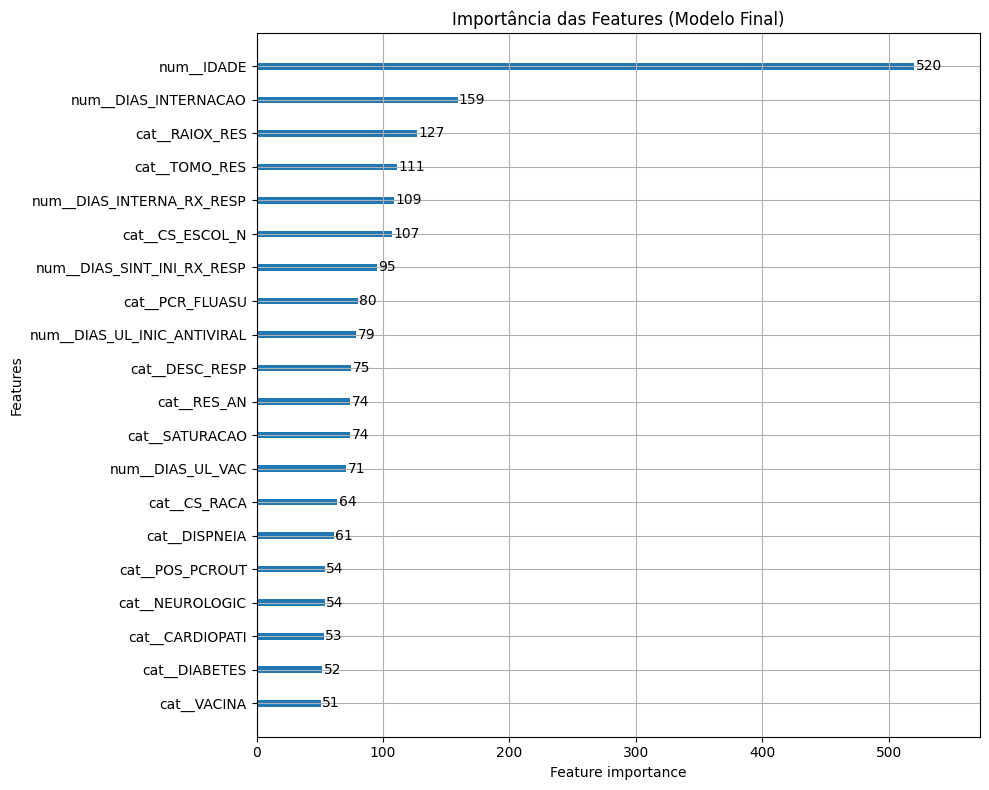


--- Processo Concluído ---


In [66]:
print(f"Total de features: {len(X.columns)}")
print(f"Features quantitativas: {len(colunas_quantitativas)}")
print(f"Features categóricas: {len(colunas_categoricas)}")

def convert_to_string(x):
    """Converte a entrada para o tipo string, para o pipeline."""
    return x.astype(str)

# ---
# Bloco 2: DEFINIÇÃO DO PIPELINE
# ---
print("\nDefinindo o pré-processamento e o pipeline...")

# 1. Transformador numérico: Preenche NaNs com mediana E escala
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# 2. Transformador categórico:
#    - Preenche NaNs com a string "AUSENTE"
#    - Converte TUDO para string (para lidar com colunas mistas de float/str)
#    - Codifica strings para inteiros (trata categorias novas como -1)
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='AUSENTE')),
    ('to_string', FunctionTransformer(convert_to_string, feature_names_out='one-to-one')),
    ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1, dtype=int))
])

# 3. Juntar os transformadores
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, colunas_quantitativas),
        ('cat', categorical_transformer, colunas_categoricas)
    ],
    remainder='passthrough' # Mantém colunas não listadas (se houver)
)

# 4. Identificar índices das features categóricas APÓS a transformação
# (Importante para o LightGBM saber quais colunas tratar como categóricas)
start_cat_index = len(colunas_quantitativas)
end_cat_index = start_cat_index + len(colunas_categoricas)
categorical_feature_indices = list(range(start_cat_index, end_cat_index))

print(f"Índices Categóricos para o LGBM: {categorical_feature_indices}")

# ---
# Bloco 3: Divisão de Treino e Teste
# ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)
print(f"\nDados divididos: {len(X_train)} para treino, {len(X_test)} para teste.")

# ---
# Bloco 4: Função 'Objective' do Optuna (Adaptada para Pipeline)
# ---
# Esta função processa os dados internamente para cada 'trial'
def objective(trial):
    # 1. Definir o espaço de busca
    params = {
        'objective': 'binary',
        'metric': 'auc',
        'boosting_type': 'gbdt',
        'n_jobs': -1,
        'random_state': 42,
        'verbose': -1,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1.0)
    }
    
    # Usamos n_estimators alto, pois o early_stopping cuidará disso
    model = lgb.LGBMClassifier(**params, n_estimators=2000)
    
    # 2. Recriar o preprocessor para este 'trial'
    # (Usamos os pipelines já definidos: numeric_transformer, categorical_transformer)
    preprocessor_obj = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, colunas_quantitativas),
            ('cat', categorical_transformer, colunas_categoricas)
        ],
        remainder='passthrough'
    )
    
    # 3. Criar conjunto de validação interna
    X_train_val, X_val, y_train_val, y_val = train_test_split(
        X_train, y_train, test_size=0.2, random_state=42
    )

    # 4. Ajustar o pré-processador SOMENTE no treino (X_train_val)
    #    e transformar ambos
    X_train_val_t = preprocessor_obj.fit_transform(X_train_val)
    X_val_t = preprocessor_obj.transform(X_val)

    # 5. Treinar o modelo com early stopping e pruning
    model.fit(
        X_train_val_t, y_train_val,
        eval_set=[(X_val_t, y_val)],
        eval_metric='auc',
        callbacks=[
            lgb.early_stopping(stopping_rounds=50, verbose=False),
            # Corrigido para 'auc' (o nome da métrica)
            optuna.integration.LightGBMPruningCallback(trial, 'auc')
        ],
        categorical_feature=categorical_feature_indices # Passando os índices!
    )
    
    # 6. Retornar a melhor pontuação de AUC
    return model.best_score_['valid_0']['auc']


# ---
# Bloco 5: Execução do Estudo de Otimização
# ---
print("\nIniciando busca de hiperparâmetros com Optuna...")
study = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner(n_warmup_steps=5))

# (n_trials=50 é um bom começo, aumente para 100-200 para melhores resultados)
study.optimize(objective, n_trials=50, show_progress_bar=True)

print("\nBusca finalizada!")
print(f"Melhor valor de AUC (na validação interna): {study.best_value:.4f}")
print(f"Melhores hiperparâmetros encontrados: {study.best_params}")


# ---
# Bloco 6: Treinamento do Modelo FINAL e Montagem do Pipeline
# ---
# Esta é a abordagem correta para evitar o erro '...do not match'
print("\nTreinando o modelo final com os melhores parâmetros...")

# 1. Pegar os melhores parâmetros
best_params = study.best_params

# 2. Instanciar o modelo final (Sintaxe corrigida: usando '=')
final_model = lgb.LGBMClassifier(
    objective='binary',
    metric='auc',
    n_jobs=-1,
    random_state=42,
    **best_params,      # Adiciona os parâmetros ótimos (ex: max_depth)
    n_estimators=2000   # Número alto, usaremos early stopping
)

# 3. Ajustar o pré-processador UMA VEZ no X_train
print("Ajustando o pré-processador final...")
# (O 'preprocessor' aqui é o objeto original do Bloco 2)
preprocessor.fit(X_train)

# Captura os nomes das features na ordem correta do preprocessor
feature_names_out = preprocessor.get_feature_names_out()

# 4. Transformar ambos os datasets (Treino e Teste)
print("Transformando dados de treino e teste...")
X_train_t = preprocessor.transform(X_train)
X_test_t = preprocessor.transform(X_test)

# 5. Treinar o modelo FINAL diretamente nos dados transformados
print("Iniciando treinamento final com early stopping...")
final_model.fit(
    X_train_t, y_train,
    eval_set=[(X_test_t, y_test)],
    callbacks=[
        lgb.early_stopping(stopping_rounds=50, verbose=False),
        lgb.log_evaluation(period=500)
    ],
    categorical_feature=categorical_feature_indices, # Crucial!
    feature_name=list(feature_names_out)
)

# 6. Criar o PIPELINE FINAL para deploy
#    Juntamos o pré-processador (JÁ AJUSTADO) e o modelo (JÁ TREINADO)
print("Montando pipeline final para deploy...")
final_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor), # pré-processador 'fitado' no X_train
    ('model', final_model)         # modelo 'fitado' no X_train_t
])

# 7. SALVAR O PIPELINE FINAL (O objeto para o Docker)
# (Usando o nome de arquivo que você especificou)
caminho_pipeline = 'modelo_lgbm.joblib' 
print(f"Salvando o pipeline completo em {caminho_pipeline}...")
joblib.dump(final_pipeline, caminho_pipeline)


# ---
# Bloco 7: Avaliação do Pipeline Final
# ---
print("\nIniciando avaliação do pipeline FINAL no conjunto de Teste...")
# Carregamos o pipeline salvo para garantir que funciona
loaded_pipeline = joblib.load(caminho_pipeline)

# O pipeline carregado espera dados "crus" (raw)
y_pred_proba = loaded_pipeline.predict_proba(X_test)[:, 1]
y_pred_class = loaded_pipeline.predict(X_test)

auc_score = roc_auc_score(y_test, y_pred_proba)
acc_score = accuracy_score(y_test, y_pred_class)

print(f"\n--- Resultados da Avaliação FINAL ---")
print(f"AUC-ROC no Teste: {auc_score:.4f}")
print(f"Acurácia no Teste: {acc_score:.4f}")

print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred_class))

# ---
# Bloco 8: Importância das Features (Bônus)
# ---
print("\nGerando gráfico de importância das features...")
try:
    lgb.plot_importance(final_model, max_num_features=20, figsize=(10, 8))
    plt.title("Importância das Features (Modelo Final)")
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Não foi possível gerar gráfico: {e}")

print("\n--- Processo Concluído ---")

## Ler modelo

In [ ]:
import joblib
import pandas as pd

# 1. Carregar o modelo
print("Carregando modelo...")
modelo_carregado = joblib.load('modelo_lgbm.joblib')

# 2. Preparar novos dados (EXATAMENTE COMO FEZ NO TREINO)
# (Veja a seção "Importante" abaixo)
novos_dados_raw = pd.DataFrame({
    'quant_1_idade': [30],
    'quant_2_valor_compra': [150.0],
    'quant_3_score_risco': [0.75],
    'cat_1_estado': ['SP'],
    'cat_2_produto': ['Produto C'],
    'cat_3_tipo_cliente': ['Novo'],
    'cat_4_canal_venda': ['Online'],
    'cat_5_codigo_regiao': ['Reg_10']
})

colunas_categoricas = [
    'cat_1_estado', 'cat_2_produto', 'cat_3_tipo_cliente', 
    'cat_4_canal_venda', 'cat_5_codigo_regiao'
]

for col in colunas_categoricas:
    # A transformação DEVE ser idêntica
    novos_dados_raw[col] = novos_dados_raw[col].astype('category')


# 3. Fazer predições
print("Fazendo predições...")
# A API do scikit-learn é mantida
probabilidades = modelo_carregado.predict_proba(novos_dados_raw)
classe_predita = modelo_carregado.predict(novos_dados_raw)

print(f"Probabilidade (Classe 0, Classe 1): {probabilidades}")
print(f"Classe Predita: {classe_predita}")

## Cria docker para deploy

In [ ]:
# app.py
import os
import joblib
import pandas as pd
from flask import Flask, request, jsonify

# 1. Inicializar o App Flask
app = Flask(__name__)

# 2. Carregar o pipeline (apenas uma vez, quando o app inicia)
model_path = "modelo_lgbm.joblib"
try:
    pipeline = joblib.load(model_path)
    print("Modelo carregado com sucesso.")
except Exception as e:
    print(f"Erro ao carregar o pipeline: {e}")
    pipeline = None

# 3. Definir um endpoint de "health check"
@app.route('/health', methods=['GET'])
def health_check():
    return jsonify({"status": "healthy"}), 200

# 4. Definir o endpoint de predição
@app.route('/predict', methods=['POST'])
def predict():
    if pipeline is None:
        return jsonify({"error": "Modelo não carregado"}), 500

    try:
        # 1. Pegar os dados JSON da requisição
        data = request.get_json(force=True)
        
        # 2. Converter o JSON para um DataFrame do Pandas
        # Esperamos um JSON no formato de 'colunas' ou 'dicionário de linhas'
        # Ex: { "col_a": [1, 2], "col_b": ["x", "y"] }
        # ou: [ { "col_a": 1, "col_b": "x" }, { "col_a": 2, "col_b": "y" } ]
        
        # Este formato é mais flexível:
        if isinstance(data, list):
            predict_df = pd.DataFrame.from_records(data)
        elif isinstance(data, dict):
             # Se for um único registro: { "col_a": 1, "col_b": "x" }
             # ou múltiplos registros: { "col_a": [1, 2], "col_b": ["x", "y"] }
            predict_df = pd.DataFrame(data)
        else:
            return jsonify({"error": "Formato JSON não suportado"}), 400

        # 3. Usar o pipeline para pré-processar E prever
        # O pipeline lida com dados "crus"
        probabilidades = pipeline.predict_proba(predict_df)
        
        # 4. Formatar a resposta
        # Vamos retornar a probabilidade da classe '1' (positiva)
        output = list(probabilidades[:, 1])
        
        return jsonify({"predictions_prob_class_1": output})

    except Exception as e:
        return jsonify({"error": str(e)}), 400

# 5. Rodar o app (apenas para debug local, NÃO para produção)
if __name__ == '__main__':
    app.run(host='0.0.0.0', port=5000, debug=True)

In [ ]:
pd.crosstab(dados['UTI'], dados['VACINA'], margins=True, margins_name='Total', normalize='columns')

In [23]:
pd.crosstab(dados['UTI'], dados['SURTO_SG'], margins=True, margins_name='Total', normalize='columns')

SURTO_SG,1.0,2.0,9.0,Total
UTI,,,,
1.0,0.269262,0.291469,0.371022,0.295286
2.0,0.730738,0.708531,0.628978,0.704714


In [51]:
dados.loc[dados['UTI']==1, 'IDADE'].mean()/365.25

np.float64(42.89636237326957)

In [49]:
dados.loc[dados['UTI']==1, 'IDADE'].std()

np.float64(11729.658616801431)

In [52]:
dados.loc[dados['UTI']==2, 'IDADE'].mean()/365.25

np.float64(37.294209289565)

In [50]:
dados.loc[dados['UTI']==2, 'IDADE'].std()

np.float64(12213.656139173283)

In [39]:
dados.head(5)

,CS_SEXO,CS_GESTANT,CS_RACA,CS_ESCOL_N,ID_PAIS,CS_ZONA,NOSOCOMIAL,AVE_SUINO,TOSSE,GARGANTA,DISPNEIA,DESC_RESP,SATURACAO,DIARREIA,VOMITO,PUERPERA,CARDIOPATI,HEMATOLOGI,SIND_DOWN,HEPATICA,ASMA,DIABETES,NEUROLOGIC,PNEUMOPATI,IMUNODEPRE,RENAL,OBESIDADE,VACINA,MAE_VAC,M_AMAMENTA,ANTIVIRAL,TP_ANTIVIR,HOSPITAL,UTI,RAIOX_RES,PCR_RESUL,POS_PCRFLU,TP_FLU_PCR,PCR_FLUASU,PCR_FLUBLI,POS_PCROUT,PCR_VSR,PCR_PARA1,PCR_PARA2,PCR_PARA3,PCR_PARA4,PCR_ADENO,PCR_METAP,PCR_BOCA,PCR_RINO,PCR_OUTRO,DOR_ABD,FADIGA,PERD_OLFT,PERD_PALA,TOMO_RES,TP_TES_AN,RES_AN,POS_AN_FLU,TP_FLU_AN,POS_AN_OUT,AN_SARS2,AN_VSR,AN_PARA1,AN_PARA2,AN_PARA3,AN_ADENO,AN_OUTRO,POV_CT,SURTO_SG,IDADE,DIAS_UL_VAC,DIAS_UL_VAC_MAE,DIAS_UL_VAC_DOSEUNI,DIAS_UL_VAC_1_DOSE,DIAS_UL_VAC_2_DOSE,DIAS_UL_INIC_ANTIVIRAL,DIAS_INTERNACAO,DIAS_INTERNA_RX_RESP,DIAS_SINT_INI_RX_RESP,DIAS_INTERNA_TOMO,DIAS_SINT_INI_TOMO
5472,F,6,4,5.0,BRASIL,1.0,NaN,NaN,1.0,2.0,1.0,1.0,1.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,6.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,2.0,2.0,6.0,1.0,1.0,1.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,NaN,NaN,NaN,NaN,5.0,3.0,NaN,NaN,NaN,NaN
7941,F,5,1,1.0,BRASIL,1.0,2.0,2.0,1.0,2.0,2.0,1.0,2.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,1.0,2.0,6.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,2.0,2.0,6.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,27432.0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN
29382,M,6,1,4.0,BRASIL,1.0,2.0,2.0,1.0,2.0,1.0,1.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,1.0,1.0,NaN,NaN,1.0,1.0,1.0,1.0,6.0,1.0,1.0,1.0,3.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.0,2.0,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,24398.0,NaN,NaN,NaN,NaN,NaN,14.0,14.0,NaN,NaN,0.0,0.0
35455,M,6,1,NaN,BRASIL,1.0,2.0,2.0,1.0,NaN,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,2.0,6.0,1.0,1.0,1.0,3.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,5.0,2.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,27505.0,NaN,NaN,NaN,NaN,NaN,5.0,2.0,NaN,NaN,2.0,2.0
38164,F,6,1,NaN,BRASIL,NaN,2.0,2.0,1.0,2.0,1.0,1.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,NaN,NaN,1.0,1.0,1.0,1.0,6.0,1.0,1.0,1.0,3.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,2.0,2.0,5.0,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,1891.0,NaN,NaN,NaN,NaN,NaN,4.0,4.0,NaN,NaN,2.0,2.0


In [41]:
len(X.columns.to_list())

81

In [43]:
for coluna in X.columns.to_list():
    print(X[coluna].unique())

['F', 'M', 'I']
Categories (3, object): ['F', 'I', 'M']
[6, 5, 1, 2, 3, 9, 4, 0]
Categories (8, int64): [0, 1, 2, 3, 4, 5, 6, 9]
[4, 1, 2, 9, 3, 5]
Categories (6, int64): [1, 2, 3, 4, 5, 9]
[5.0, 1.0, 4.0, NaN, 2.0, 9.0, 0.0, 3.0]
Categories (7, float64): [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 9.0]
['BRASIL', 'BOLIVIA', 'PARAGUAI', 'SUICA', 'ESTADOS UNIDOS DA AMERICA', 'VENEZUELA', 'GUIANA']
Categories (7, object): ['BOLIVIA', 'BRASIL', 'ESTADOS UNIDOS DA AMERICA', 'GUIANA', 'PARAGUAI', 'SUICA', 'VENEZUELA']
[1.0, NaN, 2.0, 9.0, 3.0]
Categories (4, float64): [1.0, 2.0, 3.0, 9.0]
[NaN, 2.0, 9.0, 1.0]
Categories (3, float64): [1.0, 2.0, 9.0]
[NaN, 2.0, 9.0, 1.0, 3.0]
Categories (4, float64): [1.0, 2.0, 3.0, 9.0]
[1.0, 2.0, NaN, 9.0]
Categories (3, float64): [1.0, 2.0, 9.0]
[2.0, NaN, 1.0, 9.0]
Categories (3, float64): [1.0, 2.0, 9.0]
[1.0, 2.0, NaN, 9.0]
Categories (3, float64): [1.0, 2.0, 9.0]
[1.0, NaN, 2.0, 9.0]
Categories (3, float64): [1.0, 2.0, 9.0]
[1.0, 2.0, NaN, 9.0]
Categories (3, floa